# Stackoverflow questions classification by topic

HackerRank problem of Statistics and Machine Learning

Here is a study of a case based on a HackerRank challenge. The solution is not tailored for the site, where only the output is required. I only used the problem as a question to explore.

### Setup

In [4]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import vstack 
from scipy.stats import randint
import optuna

### Algorithm

In [5]:

# Step 1: Load and preprocess the training data
def load_training_data(file_path):
    with open(file_path, 'r') as f:
        num_lines = int(f.readline().strip())
        data = [json.loads(f.readline().strip()) for _ in range(num_lines)]
    df = pd.DataFrame(data)
    return df

def preprocess_text(df):
    df['text'] = df['question'] + " " + df['excerpt']
    return df

def encode_labels(df):
    le = LabelEncoder()
    df['topic_encoded'] = le.fit_transform(df['topic'])
    return df, le

# Vectorize text
def vectorize_text(df):
    vectorizer = TfidfVectorizer(sublinear_tf=True,analyzer = 'word', max_df = 0.1, ngram_range=(1,2), max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(df['text'])
    return X, vectorizer

# Step 2: Train the model
def train_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = SGDClassifier()
    model.fit(X_train, y_train)
    # Evaluate
    y_pred = model.predict(X_val)
    print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")
    return model

# Step 3: Predict on test data
def predict_test_data(model, vectorizer, le, test_file_path):
    with open(test_file_path, 'r') as f:
        num_lines = int(f.readline().strip())
        test_data = [json.loads(f.readline().strip()) for _ in range(num_lines)]
    test_df = pd.DataFrame(test_data)
    test_df['text'] = test_df['question'] + " " + test_df['excerpt']
    X_test = vectorizer.transform(test_df['text'])
    predictions = model.predict(X_test)
    test_df['predicted_topic'] = le.inverse_transform(predictions)
    return test_df

In [6]:
# Load and preprocess training data
train_file_path = 'training.json'
df = load_training_data(train_file_path)
df = preprocess_text(df)
df, le = encode_labels(df)
X, vectorizer = vectorize_text(df)

In [7]:
# Train the model
model = train_model(X, df['topic_encoded'])

Validation Accuracy: 0.9077645895153313


In [8]:
# Predict on test data
test_file_path = 'test_data.txt'
test_df = predict_test_data(model, vectorizer, le, test_file_path)

### Predicitions

In [9]:
test_df

,question,excerpt,text,predicted_topic
0,Frequency Inverter LS IS5,I have been working with a IS5 frequency inver...,Frequency Inverter LS IS5 I have been working ...,electronics
1,Why did the designer use this motor?,I was taking apart this thing that I bought fr...,Why did the designer use this motor? I was tak...,photo
2,Help with amplifier with feedback,I am starting to learn to use operational ampl...,Help with amplifier with feedback I am startin...,electronics
3,Single Supply Op Amp to Amplify 0-3.3V to 0-10V,This may be a very basic question but as the u...,Single Supply Op Amp to Amplify 0-3.3V to 0-10...,electronics
4,How to start with 3d tracking? [on hold],I am new to all of this and I really feel over...,How to start with 3d tracking? [on hold] I am ...,scifi
...,...,...,...,...
15027,Add exception to WP Mobile Detector,In the function websitez_detect_mobile_device ...,Add exception to WP Mobile Detector In the fun...,wordpress
15028,Query Problem in getting top viewed posts,"I wanted to display top viewed posts by month,...",Query Problem in getting top viewed posts I wa...,wordpress
15029,Translate Woosidebars plugin strings,I'm trying to translate Woosidebars strings i...,Translate Woosidebars plugin strings I'm tryi...,wordpress
15030,Fatal error: Allowed memory size of 37748736 b...,I hope this is not a duplicate question.\n\nI ...,Fatal error: Allowed memory size of 37748736 b...,wordpress


In [10]:
# Save predictions
#test_df[['question', 'excerpt', 'predicted_topic']].to_csv('predictions.csv', index=False)

### More about validation

In [11]:
# Split data into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, df['topic_encoded'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
model.fit(X_train, y_train)

SGDClassifier()

In [13]:
y_val_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.9004286185295087


In [14]:
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.9004606915957578
Recall: 0.9004286185295087
F1-Score: 0.8999767994017619


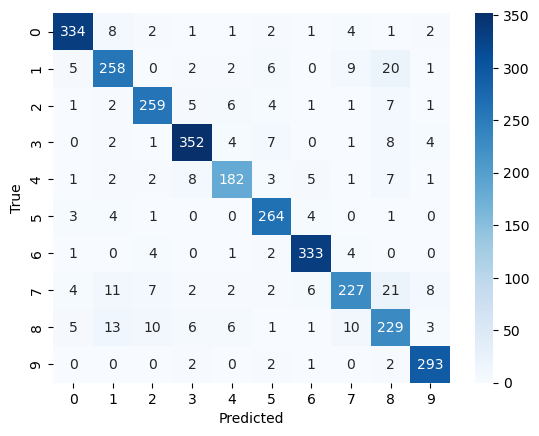

In [15]:
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       356
           1       0.86      0.85      0.86       303
           2       0.91      0.90      0.90       287
           3       0.93      0.93      0.93       379
           4       0.89      0.86      0.88       212
           5       0.90      0.95      0.93       277
           6       0.95      0.97      0.96       345
           7       0.88      0.78      0.83       290
           8       0.77      0.81      0.79       284
           9       0.94      0.98      0.96       300

    accuracy                           0.90      3033
   macro avg       0.90      0.90      0.90      3033
weighted avg       0.90      0.90      0.90      3033



In [17]:
scores = cross_val_score(model, X, df['topic_encoded'], cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {scores.mean()} ± {scores.std()}")

Cross-Validation Accuracy: 0.9066721419321914 ± 0.0060270164312028925


### Comparing Models

In [18]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "SGD" : SGDClassifier()
}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    print(f"{name} - Accuracy: {accuracy}, F1-Score: {f1}")

/Users/leticiaglass/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Accuracy: 0.897131552917903, F1-Score: 0.8969055965965675
Random Forest - Accuracy: 0.8170128585558852, F1-Score: 0.8157154988943847
SVM - Accuracy: 0.8931750741839762, F1-Score: 0.8936292557389084
SGD - Accuracy: 0.9004286185295087, F1-Score: 0.9000413825947909


Once I've selected the best model (SGD) based on the validation set, I'll evaluate it on the test set to get an unbiased estimate of its performance

In [19]:
best_model = SGDClassifier()

X_train_full = vstack([X_train, X_val]) # using vstack to concatenate matrix vertically
y_train_full = pd.concat([y_train, y_val])

best_model.fit(X_train_full, y_train_full)

# Predict
y_test_pred = best_model.predict(X_test)

In [20]:
# comparing true & predicted - evaluate 
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.9172436531486977
Precision: 0.9172754836959867
Recall: 0.9172436531486977
F1-Score: 0.9169201589672001


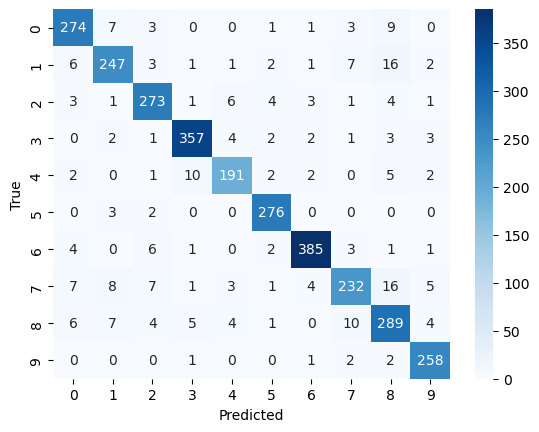

In [21]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Tune the hyperparameters 

Tunning a Random Forest Model with GridSearch:

GridSearchCV performs an exhaustive search over all combinations of parameters in the grid.
It uses cross-validation (cv=5) to evaluate each combination.

Mesmo que RandomForest não é o melhor modelo para esse problema, usando apenas para estudos. 

In [22]:
# Define the parameter grid
param_grid = {
    'n_estimators': [20, 50],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5],  # Minimum samples to split a node
    'min_samples_leaf': [2, 4],    # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2']   # Number of features to consider for splits
}

# Create the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',  # Metric to optimize
    cv=5,               # 5-fold cross-validation
    n_jobs=-1           # Use all available CPU cores
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score}")

# Train the best model on the full training set
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_full, y_train_full)

# Evaluate on the test set
y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with Best Model: {test_accuracy}")

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.8589705094904596
Test Accuracy with Best Model: 0.8684470820969338


Tunning with Randomized Search CV - is more efficient because it randomly samples a fixed number of combinations.

In [23]:
# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),       # Randomly sample between 50 and 200
    'max_depth': [None, 10, 20],        # Fixed choices
    'min_samples_split': randint(2, 10),    # Randomly sample between 2 and 10
    'min_samples_leaf': randint(1, 4),      # Randomly sample between 1 and 4
    'max_features': ['sqrt', 'log2']        # Fixed choices
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,               # Number of parameter settings to sample
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score}")

# Train the best model on the full training set
best_rf = random_search.best_estimator_
best_rf.fit(X_train_full, y_train_full)

# Evaluate on the test set
y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with Best Model: {test_accuracy}")

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 138}
Best Cross-Validation Accuracy: 0.8633509616524769
Test Accuracy with Best Model: 0.8737223870755028


### Bayesian Optimization

Trying bayesian optimization with random forest model to reach out the best hyperparameters 

In [28]:
def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30, step=5)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Create the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()  # Return the mean accuracy

In [29]:
# Create a study object and optimize
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials

# Print the best hyperparameters and best score
print(f"Best trial: {study.best_trial.params}")
print(f"Best accuracy: {study.best_trial.value}")

[I 2025-03-22 15:05:43,646] A new study created in memory with name: no-name-a2c7466e-c56b-4428-9ef0-6b800c0a512d
[I 2025-03-22 15:05:45,669] Trial 0 finished with value: 0.7064237811309168 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7064237811309168.
[I 2025-03-22 15:05:47,221] Trial 1 finished with value: 0.6942706756218695 and parameters: {'n_estimators': 169, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.7064237811309168.
[I 2025-03-22 15:05:48,376] Trial 2 finished with value: 0.7728405475471589 and parameters: {'n_estimators': 77, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.7728405475471589.
[I 2025-03-22 15:05:51,384] Trial 3 finished with value: 0.7047982895080089 and parameters: {'n_estimators': 200, 'max_depth': 10, 'mi

Best trial: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best accuracy: 0.8080981510859703


In [30]:
# Get the best hyperparameters
best_params = study.best_trial.params

# Train the best model on the full training set
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_full, y_train_full)

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with Best Model: {test_accuracy}")

Test Accuracy with Best Model: 0.815694032311243


In [31]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study)

# Plot hyperparameter importance
optuna.visualization.plot_param_importances(study)